# homework 06: Student's game night


In [1]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


The student-game.py script can be used to generate a random sample of a given length and output much of the necessary information about that simulated run of the game. I have done so below with a sample size of 3

Welcome to Student's game night...

The RNG seed is 7976

The hidden grid has 20 rows for sigma 100.0..5.0,
                and 21 cols for mu -100.0..100.0.

Student picked grid col = 1, row = 15
and thus mu = -90.0, sigma = 25.0

Student's tea distribution machine shows the customers 3 samples:
    -64.23
   -117.25
   -102.38

which give sample mean:   -94.62
   and sample std.dev.:    27.34


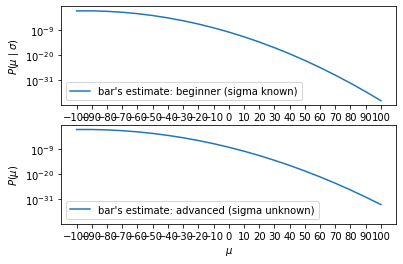

In [2]:
run student-game.py 3

From this script, we can obtain the following variables\
Known variables:\
X - list of samples\
sample_mean\
sample_stdev\
PrB- bars probabilities for odds of mu given the sample for the beginner game\
PrA- bars probabilities for odds of mu given the sample and true stdev for the advanced game\
true sigma (known if beginner, hidden if advanced)

Hidden variables:\
true_mu

Instead of always calling the student-game script, I have incorporated functions from the script into my own Jupyter notebook so that they can be easily callable.

In [3]:
#these never change
gridrows = np.linspace( 100.0,   5.0, 20)   # rows i of the grid are sigma, std. dev.
gridcols = np.linspace(-100.,  100.0, 21)   # columns j of the grid are mu, mean (location)


In [4]:
# The inference rules that Student uses to calculate betting odds
# from: these give him what he thinks are the expected P(mu | x1..xn,
# sigma) distribution.
#
def probdist_beginner(X, sigma, mu_values):
    """ 
    Given an ndarray X_1..X_n, and a known sigma;
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X,sigma) for each column.
    """
    xbar = np.mean(X)
    N    = len(X)
    Pr   = [ stats.norm.pdf(x, loc=xbar, scale= sigma / np.sqrt(N)) for x in mu_values ]  # proportional to std error of the mean
    Z    = sum(Pr)                   # normalization constant
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr

def probdist_advanced(X, mu_values):
    """ 
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column.
    """
    xbar = np.mean(X)
    s    = np.std(X, ddof=1)     # note that numpy.sd() by default calculates a population std dev; to get sample std. dev., set ddof=1
    N    = len(X)
    Pr   = [ stats.norm.pdf(x, loc=xbar, scale= s / np.sqrt(N)) for x in mu_values ]  # proportional to std error of the mean
    Z    = sum(Pr)                   # normalization constant
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr

def tdist_advanced(X, mu_values):
    """ 
    Given an ndarray X_1..X_n,
    and a list of the mu values in each column;
    return a list of the inferred P(mu | X) for each column,
	according to a Student's t distribution with N-1 degrees of freedom.
    """
    N    = len(X)
    t    = [ stats.ttest_1samp(X, mu)[0] for mu in mu_values ]
    Pr   = [ stats.t.pdf(val, N-1) for val in t ]
    Z    = sum(Pr)
    Pr   = [ p / Z for p in Pr ]     # normalization to a discrete probability distribution
    return Pr


In [5]:
def run_student_game (nX):
    #input:
    #nX- number of runs
    
    # Set up the 20x21 dart board grid, and the mu and sigma values
    # associated with each grid position.
    #
    gridrows = np.linspace( 100.0,   5.0, 20)   # rows i of the grid are sigma, std. dev.
    gridcols = np.linspace(-100.,  100.0, 21)   # columns j of the grid are mu, mean (location)
    nrows    = len(gridrows)
    ncols    = len(gridcols)

    # Student throws a uniformly distributed dart into the grid, and this
    # chooses mu, sigma. These values are unknown to the customers.
    #
    true_row = np.random.randint(0, nrows)    # Note, randint(0,n) samples 0..n-1
    true_col = np.random.randint(0, ncols)

    true_sigma = gridrows[true_row]
    true_mu    = gridcols[true_col]

    # Student's tea distribution machine drops observed samples onto the
    # line on the bar: nX of them, X[0..nX-1]
    #
    X  = np.random.normal(loc=true_mu, scale=true_sigma, size=nX)

    sample_mean  = np.mean(X)
    sample_stdev = np.std(X, ddof = 1)   ## ddof is "degrees of freedom". 0 = population sd; 1 = sample sd.
    
    # The bar's rules for determining fair odds.
    #
    PrB = probdist_beginner(X, true_sigma, gridcols)
    PrA = probdist_advanced(X, gridcols)

    return X, sample_mean, sample_stdev, PrB, PrA, true_sigma, true_mu

In [6]:
def graph_semilogplots(PrB,PrA,gridcols):
    # Set up our graphical display.
    #
    # We'll show the pub's supposedly "fair odds" probability distribution plot for the
    # beginner version and the advanced version, as semilog plots.
    #
    f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col

    ax1.semilogy(gridcols, PrB, label="bar's estimate: beginner (sigma known)")
    ax1.xaxis.set_ticks(gridcols)
    ax1.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
    ax1.legend(loc="best")

    ax2.semilogy(gridcols, PrA, label="bar's estimate: advanced (sigma unknown)")
    ax2.xaxis.set_ticks(gridcols)
    ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
    ax2.legend(loc="best")

    plt.show()


The p-set provides an example of a sample size of three drawn from a known $\mu$ and $\sigma$ 

In [7]:
#example given in the p-set
X_ex          = np.array([ 11.50, -2.32, 9.18]) # n=3 observations
true_sigma_ex = 60.                             # Student also tells you this in beginner's game
true_mu_ex    = -20.                            # the unknown column position, mu
PrB_ex = probdist_beginner(X_ex, true_sigma_ex, gridcols)
PrA_ex = probdist_advanced(X_ex, gridcols)

## 1. the beginner's game

For the beginner game, I have a script that can take any integer n for the sample size of teabags dropped and returns a random sample and the true $\sigma$ and calculates the posterior probabilities for each possible $\mu$ value. It then plots those posterior probabilities along with the bar's estimate for the probabilities for each $\mu$ value on a single figure. I have done this both for a random sample with $n=10$ and with the example sample given from the p-set.

Note: because there is a uniform prior (each $\mu$ value is equally likely) I do not need to account for the probability $P(\mu)$ because it is the same for each $\mu$ value and it would just get cancelled out when the probabilities are normalized at the end.

In [8]:
#can set number of observations as any integer n
n=10

X, sample_mean, sample_stdev, PrB, PrA, true_sigma, true_mu  = run_student_game(n)
#the only outputs we actually use in the beginning game are:
#X
#PrB
#true_sigma
#gridcols

In [9]:
def get_postprobs_b (X, true_sigma, gridcols):
    P_per_mu = [] #in log scale
    for mu in gridcols:
        p=0
        for i in X:
            p += stats.norm.logpdf(i,mu,true_sigma)
            #This is how the probability for each point in the sample is calculated
        P_per_mu.append(p)
    
    #normalizing so that the probabilities sum to 1
    P_per_mu_normalized=[]
    
    for i in P_per_mu:
        P_per_mu_normalized.append(np.exp(i)/sum(np.exp(P_per_mu)))
    return P_per_mu_normalized

In [10]:
#run for the random sample we generated above:
trueprobs = get_postprobs_b(X, true_sigma,gridcols)

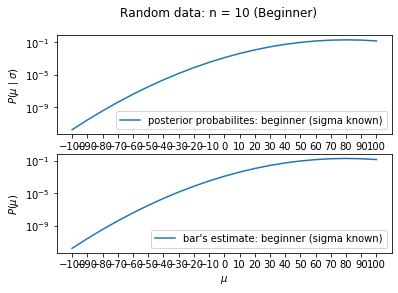

In [11]:
#code for making figure drawn from student-game script
f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col

ax1.semilogy(gridcols, trueprobs, label="posterior probabilites: beginner (sigma known)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
ax1.legend(loc="best")

ax2.semilogy(gridcols, PrB, label="bar's estimate: beginner (sigma known)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax2.legend(loc="best")

plt.suptitle('Random data: n = '+str(n)+' (Beginner)')
plt.show()


They look exactly the same- no advantage to be gained here! 

Let's do the same with the example from the p-set:

In [12]:
trueprobs_ex = get_postprobs_b(X_ex, true_sigma_ex,gridcols)

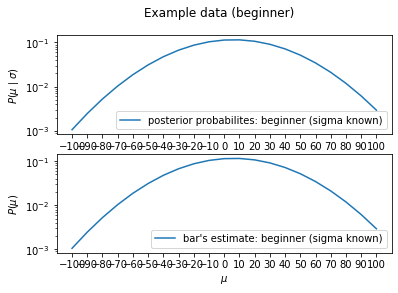

In [13]:
f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col

ax1.semilogy(gridcols, trueprobs_ex, label="posterior probabilites: beginner (sigma known)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
ax1.legend(loc="best")

ax2.semilogy(gridcols, PrB_ex, label="bar's estimate: beginner (sigma known)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax2.legend(loc="best")

plt.suptitle('Example data (beginner)')

plt.show()


Again, the posterior probabilities for the beginner game and the bar's estimate of probabilities for the beginner game are exactly the same-no advantage here. The highest probability falls around the sample mean of the example data.

## 2. the advanced game
I will use the same randomly-generated data from section 1 (with n=10 tea bags dropped) but calculate the posterior probabilities for the advanced game, when the true_sigma is unknown. In order to do this, I first calculate the posterior probability for each possible $\mu$ and $\sigma$ combination. I plot as a heat map where each of the 420 posterior probabilities are plotted by $\mu$ and by $\sigma$. I then marginalize the posterior probabilities for each $\mu$ value, and plot posterior probability of each $\mu$ value and comare it to the bar's estimation for the probability of each $\mu$ value according to the advanced game method. I do each of these steps both for the same random 10-point sample from section 1 and for the example data from the p-set.

Note: because there is a uniform prior (each $\mu$ and $\sigma$ value are equally likely and they are independent) I do not need to account for the probability $P(\mu,\sigma)$ because it is the same for each $\mu$ and $\sigma$ value and it would just get cancelled out when the probabilities are normalized at the end.

In [14]:
def get_postprobs_a (X, gridcols,gridrows):
    P_per_mu_sig = np.zeros([len(gridcols),len(gridrows)]) #in log scale
    for i in range(len(gridcols)):
        mu=gridcols[i]
        for j in range(len(gridrows)):
            sigma=gridrows[j]
            p=0
            for k in X:
                p += stats.norm.logpdf(k,mu,sigma)
                #here the probability for each point in the sample is calcuated given the mu and sigma values
            P_per_mu_sig[i,j]=p

    P_per_mu_sig_unlogged = np.exp(P_per_mu_sig) #converting from log scale back into standard scale   
    P_per_mu_sig_unlogged_norm = np.divide(P_per_mu_sig_unlogged,np.sum(np.sum(P_per_mu_sig_unlogged)))
    #the posterior probabilities are normalized and ready for the heat map
    
    #marginalizing this matrix along the mu axis to get probabilitiy for each mu
    P_per_mu = np.sum(P_per_mu_sig_unlogged,axis=1) #not in log scale
    
    #normalizing so the sum of P(mu) for all mus =1
    P_per_mu_normalized=[]
    for i in P_per_mu:
        P_per_mu_normalized.append(i/sum(P_per_mu))
    return P_per_mu_sig_unlogged_norm, P_per_mu_normalized

In [15]:
trueA, trueAmarg = get_postprobs_a(X, gridcols, gridrows)

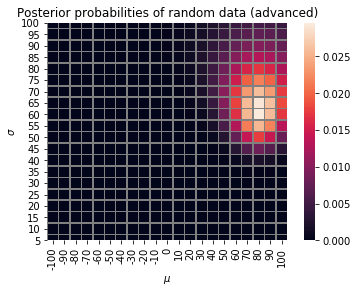

In [16]:
# Format axis labels as strings, with values as "10" not "10.0" for clarity, space
xlabels = [ "{0:.0f}".format(val) for val in gridcols ]
ylabels = [ "{0:.0f}".format(val) for val in gridrows ]

# the Seaborn "heatmap" plot
# with some examples of how it can be customized.
#
ax = sns.heatmap(np.transpose(trueA),  # takes a 2D array of data
                 xticklabels=xlabels,  #   ... set custom x axis labels
                 yticklabels=ylabels,  #   ... set custom y axis labels
                 cbar=True,            #   ... turn off the default color scale bar
                 square=True,          #   ... force the plot to be square
                 linecolor='grey',     #   ... set grid line color
                 linewidth=0.5)        #   ... set grid line width

ax.set_title('Posterior probabilities of random data (advanced)')
# now we have an Axes object that Seaborn returned to us,
# and we can do additional customization, like...

ax.set(xlabel='$\mu$',                 # ...set X axis label, using LaTeX formatting
       ylabel='$\sigma$')              # ...and Y axis label
for label in ax.get_yticklabels():    
    label.set_size(10)                 # ... and font size on y-axis tick labels
for label in ax.get_xticklabels():    
    label.set_size(10)                 # ... and on x-axis tick labels



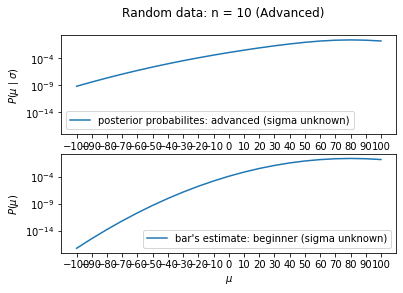

In [17]:
f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col

ax1.semilogy(gridcols, trueAmarg, label="posterior probabilites: advanced (sigma unknown)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
ax1.legend(loc="best")

ax2.semilogy(gridcols, PrA, label="bar's estimate: beginner (sigma unknown)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax2.legend(loc="best")

plt.suptitle('Random data: n = '+str(n)+' (Advanced)')

plt.show()

There is a clear difference! The bar more often than not overestimates the values of the more likely values of $\mu$ and underestimates the probabilities of the more unlikely values of $\mu$.

Now let's do it with the example data:

In [18]:
trueA_ex, trueAmarg_ex = get_postprobs_a(X_ex, gridcols, gridrows)

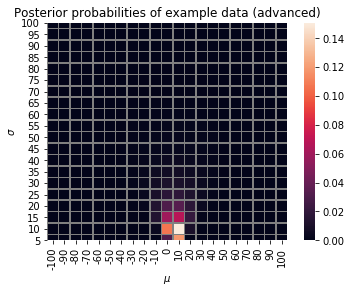

In [19]:
# Format axis labels as strings, with values as "10" not "10.0" for clarity, space
xlabels = [ "{0:.0f}".format(val) for val in gridcols ]
ylabels = [ "{0:.0f}".format(val) for val in gridrows ]

# the Seaborn "heatmap" plot
# with some examples of how it can be customized.
#
ax = sns.heatmap(np.transpose(trueA_ex), # takes a 2D array of data
                 xticklabels=xlabels,    #   ... set custom x axis labels
                 yticklabels=ylabels,    #   ... set custom y axis labels
                 cbar=True,              #   ... turn off the default color scale bar
                 square=True,            #   ... force the plot to be square
                 linecolor='grey',       #   ... set grid line color
                 linewidth=0.5)          #   ... set grid line width

# now we have an Axes object that Seaborn returned to us,
# and we can do additional customization, like...

ax.set_title('Posterior probabilities of example data (advanced)')

ax.set(xlabel='$\mu$',                 # ...set X axis label, using LaTeX formatting
       ylabel='$\sigma$')              # ...and Y axis label
for label in ax.get_yticklabels():    
    label.set_size(10)                 # ... and font size on y-axis tick labels
for label in ax.get_xticklabels():    
    label.set_size(10)                 # ... and on x-axis tick labels



The heat map shows that according to the posterior probabilities the $\mu$ is estimated to be ~10, which is close to the sample mean (below), and, interestingly, that $\sigma$ is rather low– also ~10, which is close to the sample standard deviation (below). The $\mu$ is not too far off, but $\sigma$ is quite off- we know that the true $\sigma$ is 60.

Although this is not a correct prediction when we take into account the true parameters, given the sample mean and sample standard deviation it is a sensible prediction.

In [20]:
print(X_ex.mean())
print(X_ex.std())

6.12
6.042670491319766


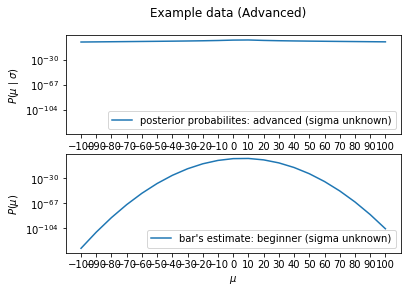

In [21]:
f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col

ax1.semilogy(gridcols, trueAmarg_ex, label="posterior probabilites: advanced (sigma unknown)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
ax1.legend(loc="lower right")

ax2.semilogy(gridcols, PrA_ex, label="bar's estimate: beginner (sigma unknown)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax2.legend(loc="best")

plt.suptitle('Example data (Advanced)')

plt.show()

Here is the same plot but where the y-axes are different for each graph. This allows for visualization of the shape of the posterior probabilities graph:

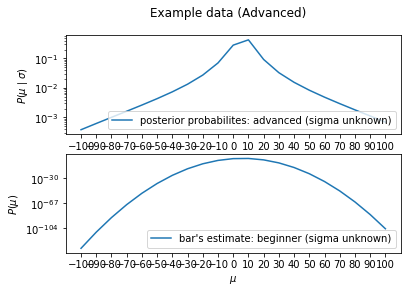

In [22]:
f, (ax1, ax2) = plt.subplots(2,1, sharey=False)  # figure consists of 2 graphs, 2 rows x 1 col

ax1.semilogy(gridcols, trueAmarg_ex, label="posterior probabilites: advanced (sigma unknown)")
ax1.xaxis.set_ticks(gridcols)
ax1.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
ax1.legend(loc="lower right")

ax2.semilogy(gridcols, PrA_ex, label="bar's estimate: beginner (sigma unknown)")
ax2.xaxis.set_ticks(gridcols)
ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
ax2.legend(loc="best")

plt.suptitle('Example data (Advanced)')

plt.show()

Notice that the shape of each graph is different, but more importantly, the posterior probabilities only go as low as $\sim 10^{-3}$. In the bar's estimate, the posterior probabilities go lower than $\sim 10^{-100}$. The reason that the bar's estimate for the posterior probabilities generates a graph that is way too narrow is that the bar's estimate relies on using the sample standard deviation as an input. For this particular data set, the true $\sigma$ equals 60 but the sample standard deviation equals 6. Because the sample standard deviation is so off, the bar's estimate is also very far off.

Now, I will run the student game 5 times for various sample sizes and plot the semi-log plots for the advanced posterior probabilities and the bar's probability estimates for the advanced. This will hopefully give a sense of how the bar's estimates differ from the true posterior probabilities with different sample sizes.

In [23]:
runs = 5
nXes = [3, 5, 7, 20, 100]

In [24]:
def highthroughput(nX):
    #This function takes nX (sample size) and creates a random sample, calculates the posterior
    #probabilities according to the advanced game, and plots those posterior probabilities on a
    #plot along with the bar's estimates for the probabilities according to the advanced game.
    
    X, sample_mean, sample_stdev, PrB, PrA, true_sigma, true_mu  = run_student_game(nX)
    trueA, trueAmarg = get_postprobs_a(X, gridcols, gridrows)
    f, (ax1, ax2) = plt.subplots(2,1, sharey=True)  # figure consists of 2 graphs, 2 rows x 1 col
    
    ax1.semilogy(gridcols, trueAmarg, label="posterior probabilites: advanced (sigma unknown)")
    ax1.xaxis.set_ticks(gridcols)
    ax1.set(xlabel='$\mu$', ylabel='$P(\mu \mid \sigma)$')
    ax1.legend(loc="lower right")

    ax2.semilogy(gridcols, PrA, label="bar's estimate: beginner (sigma unknown)")
    ax2.xaxis.set_ticks(gridcols)
    ax2.set(xlabel='$\mu$', ylabel='$P(\mu)$')
    ax2.legend(loc="best")

    plt.suptitle('Sample size = '+str(nX))

    plt.show()

### Sample size 3

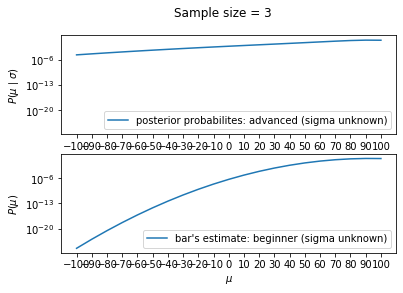

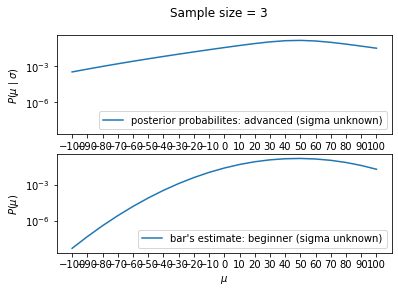

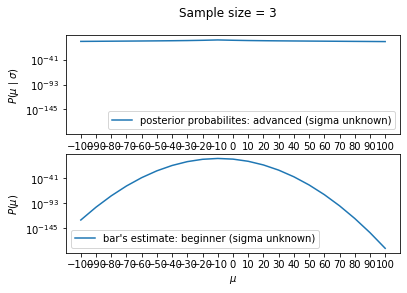

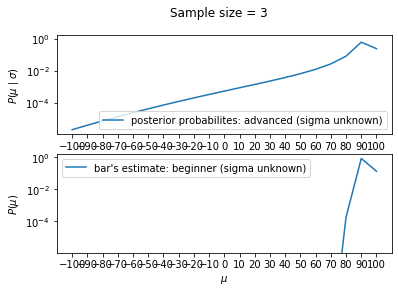

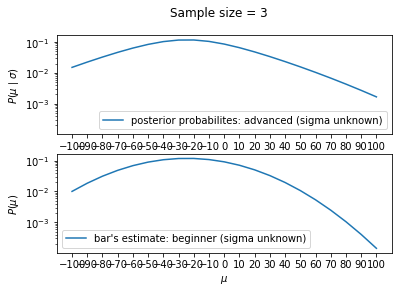

In [25]:
nX = nXes[0]
for run in range(runs):
    highthroughput(nX)

### Sample size 5

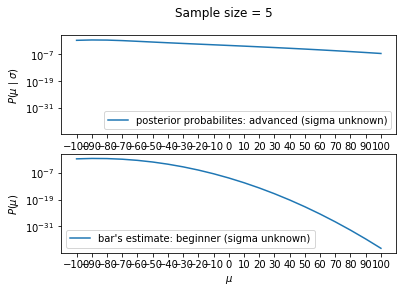

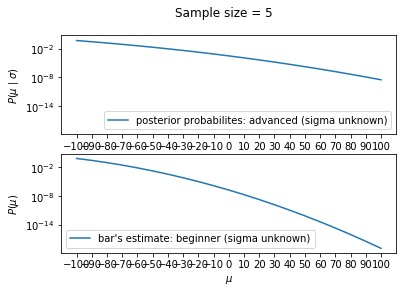

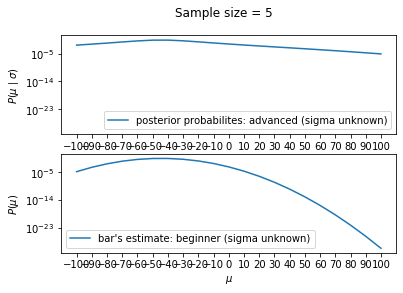

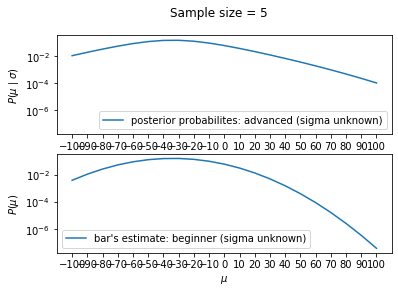

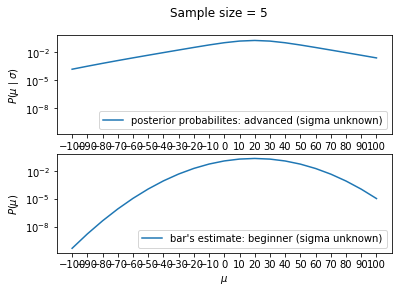

In [26]:
nX = nXes[1]
for run in range(runs):
    highthroughput(nX)

### Sample size 7

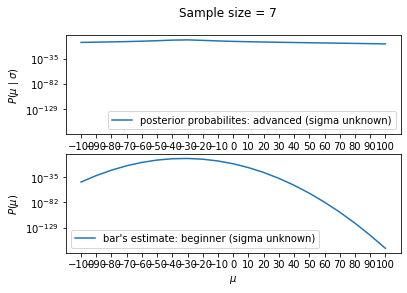

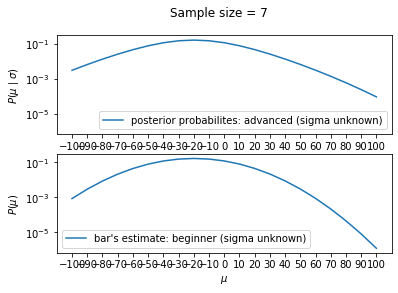

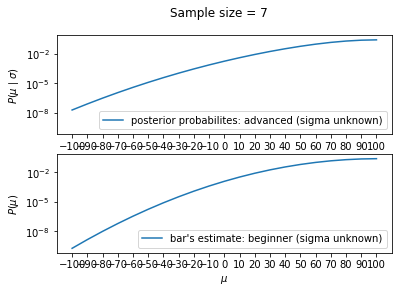

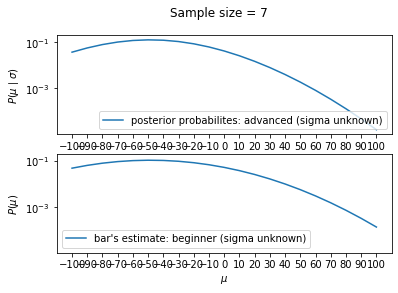

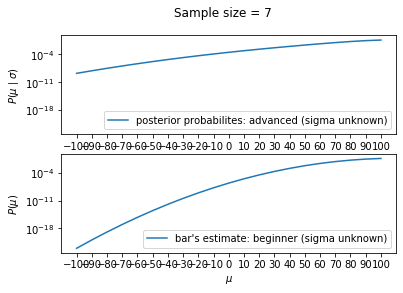

In [27]:
nX = nXes[2]
for run in range(runs):
    highthroughput(nX)

### Sample size 10

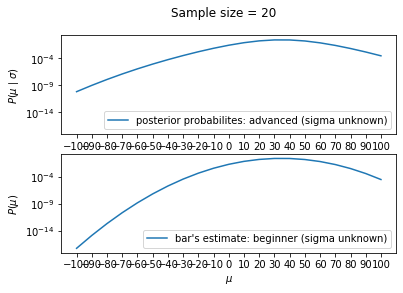

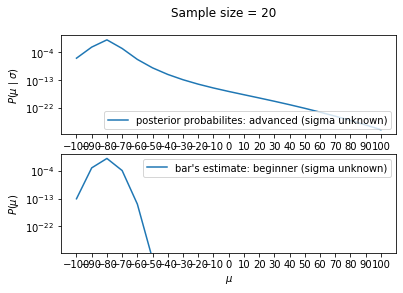

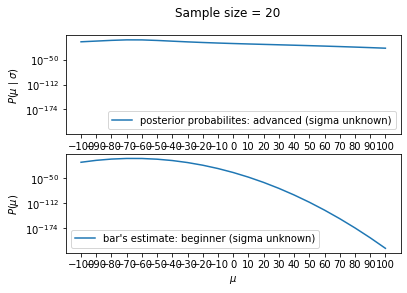

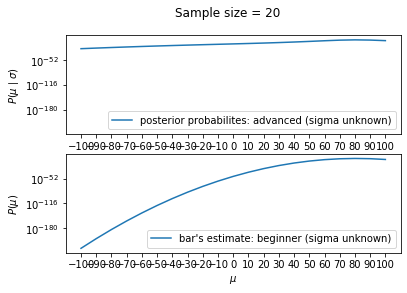

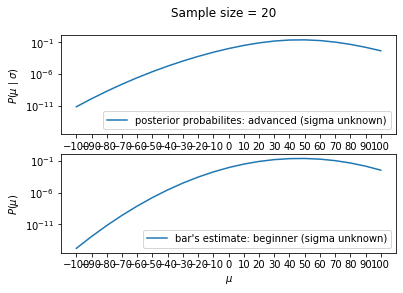

In [28]:
nX = nXes[3]
for run in range(runs):
    highthroughput(nX)

### Sample size 30

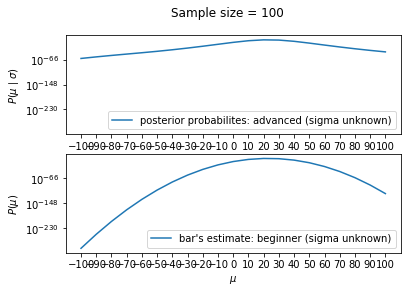

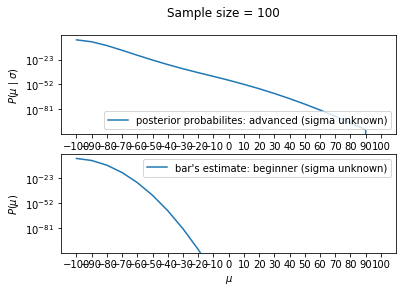

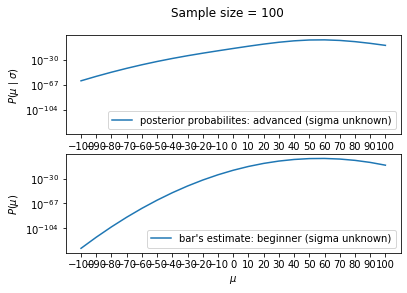

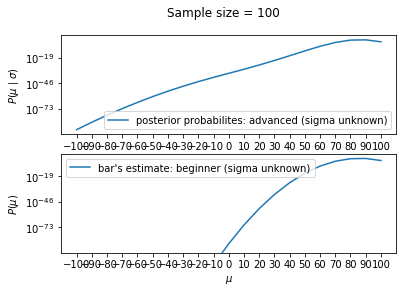

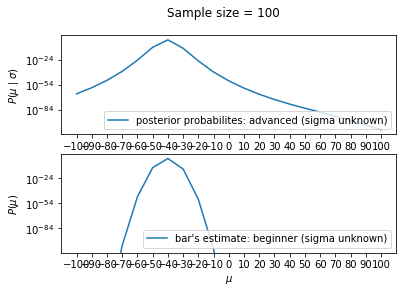

In [29]:
nX = nXes[4]
for run in range(runs):
    highthroughput(nX)

Overall, the bar's estimate tends to underestimate the probability for $\mu$ values further from the sample mean (when compared to the posterior probabilities). This is especially true for small sample sizes. 

Occasionally, the opposite happens and the bar overestimates the probability for $\mu$ values further from the sample mean. I suspect that this happens if the sample standard deviation is especially large compared to the true standard deviation parameter.

## 3. where's the advantage?


The pub is calculating the odds correctly for the beginner version of the game, but it is miscalculating the odds for the advanced version of the game. More often than not, the bar overestimates the probabilities of $\mu$ values close to the sample mean and underestimates the probabilities of $\mu$ values far from the sample mean. This effect is more pronounced for smaller sample sizes (as demonstrated above; for the example from the p-set with a sample size of 3, there is an extreme difference between the bar's estimate and the true posterior probabilities, but the difference is much smaller for the randomized run with sample size of 10). 

I suspect that this has to do with the fact that in the advanced game, the unknown true location of $\mu$ is assumed to be distributed proportional to a normal distribution with mean $\bar{x}$ and standard deviation $\dfrac{s}{\sqrt{n}}$, where $\bar{x}$ is the sample mean, $s$ is the sample standard deviation, and $n$ is the sample size. This differs from the beginner game where $s$ is replacing $\sigma$, the true standard deviation. 

I have shown below that for small sample sizes, the standard deviation of a sample is smaller than the standard deviation parameter >50% of the time. As the sample size increases, the true standard deviation will approach the true standard deviation.

Thus, if for small sample sizes $s$ is an underestimation of $\sigma$, then when the bar calculates the probabilities proportional to a normal curve it is using a narrower normal curve than it should use, which leads to 

In [30]:
dummies = 1000
for nX in [3,5,10,25,100,10000]:
    print('Sample size of '+str(nX)+':')
    isgreater = 0
    for dummy in range(dummies):
        X, sample_mean, sample_stdev, PrB, PrA, true_sigma, true_mu = run_student_game(nX)
        if(sample_stdev>true_sigma):
            isgreater+=1
        elif(sample_stdev==true_sigma):
            isgreater+=0.5
    print('Sample stdev was greater than true_sigma in '+str(100*isgreater/dummies)+'% of runs')

Sample size of 3:
Sample stdev was greater than true_sigma in 38.3% of runs
Sample size of 5:
Sample stdev was greater than true_sigma in 38.4% of runs
Sample size of 10:
Sample stdev was greater than true_sigma in 43.7% of runs
Sample size of 25:
Sample stdev was greater than true_sigma in 47.0% of runs
Sample size of 100:
Sample stdev was greater than true_sigma in 48.2% of runs
Sample size of 10000:
Sample stdev was greater than true_sigma in 51.4% of runs


Because the odds are underestimated for $\mu$ values further away from the sample mean in the advanced version of the game when the sample size is low, there is an advantage to betting on these $\mu$ values. While this could be a lucrative strategy, it is a strategy that requires patience given that these $\mu$ values are still much less likely to be the true $\mu$ parameter than those close to the sample mean.